<a href="https://colab.research.google.com/github/bayashi-cl/statistical-learning/blob/main/note/10_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install skorch

# 10 ディープラーニング

**ディープラーニング**：多層の人口ニューラルネットワークを効率的に訓練する方法。

**ニューラルネットワーク**：パーセプトロンを多層に重ねたもの

**パーセプトロン**：神経細胞をモデル化したもの。複数の入力から一つの出力をする



<img src="https://upload.wikimedia.org/wikipedia/commons/b/bc/Neuron_Hand-tuned.svg" width="30%">

(wikipedia [神経細胞](https://ja.wikipedia.org/wiki/%E7%A5%9E%E7%B5%8C%E7%B4%B0%E8%83%9E))

↓モデル化

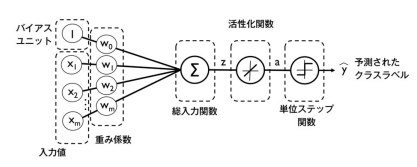

([Python機械学習プログラミング 達人データサイエンティストによる理論と実践](https://book.impress.co.jp/books/1120101017) p.335)

## 10.1 単層ニューラルネットワーク

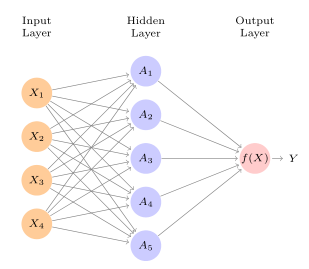

ニューラルネットワークは $p$ 要素のベクトル $X = (X_1, \dots , X_p)$ を入力にとる非線形関数 $f(X)$ として機能し、応答変数 $Y$ を出力する。

上の図では説明変数 $X_1, \dots , X_4$ が**入力層**となり、**隠れ層**へ接続されている。

このニューラルネットワークを式で表すと（$K$ は隠れ層のニューロンの数）

$$
\begin{aligned}
  Y = f(X) &= \beta_0 + \sum_{k = 1}^{K}\beta_k h_k(X)\\
  &= \beta_0 + \sum_{k = 1}^{K}\beta_k g(w_{k, 0} + \sum_{j = 0}^{p}w_{k, j} X_j)
\end{aligned}
$$

この関数は2つのステップから成る。

まず各 $k$ について $A_k$ を計算する。これは入力として $X$ をとる。

$$A_k = h_k(X) = g(w_{k, 0} + \sum_{j = 0}^{p}w_{k, j} X_j)$$

$g(z)$ は**活性化関数**と呼ばれる

その後、$A$を入力とする線形回帰を行って出力を得る。

$$f(X) = \beta_0 + \sum_{k = 1}^{K}\beta_k A_k$$

ここでは、パラメータとして$\beta_0, \dots , \beta_K, w_{1,0},\dots ,w_{K,p}$を推定する必要がある。

### 活性化関数

出力を非線形にする関数。以前は**シグモイド関数**が使われていたが、近年は**ReLU関数**が用いられることが多い。

* シグモイド関数

$$g(z) = \frac{e^z}{1 + e^z} = \frac{1}{1 + e^{-z}}$$

* ReLU関数

$$
g(z) = (z)_+ = 
\begin{cases}
  0 & \textrm{if}~~z < 0 \\
  z & \textrm{otherwise.}
\end{cases}
$$

活性化関数は非線形であることが重要で、もし線形なものをを使うと多層にする意味がなくなる。

In [ ]:
from math import exp

import matplotlib.pyplot as plt
import numpy as np

def relu(z):
    return max(z, 0)


def sigmoid(z):
    return 1 / (1 + exp(-z))


x = np.linspace(-3, 3, 100)
y_relu = np.array([relu(xi) for xi in x])
y_sigmoid = np.array([sigmoid(xi) for xi in x])
fig, ax = plt.subplots()
ax.plot(x, y_relu, label="ReLU")
ax.plot(x, y_sigmoid, label="sigmoid")
ax.legend()

plt.show()


学習をするうえでの損失関数としては二乗誤差が使われる事が多い。

## 10.2 多層ニューラルネットワーク

隠れ層を複数用意したもの。

多層ニューラルネットワークの例として手書き文字の分類問題`MNIST`を考える。このデータセットには、手書きの数字が $28 \times 28 = 784$ ピクセルのグレースケールの画像として含まれている。

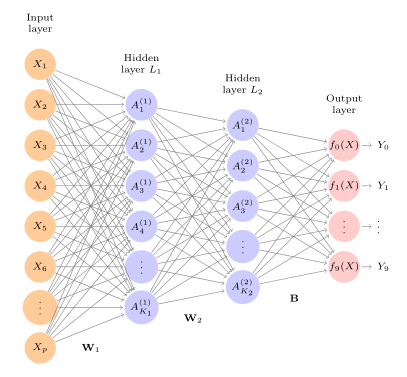

上の図が今回使うモデルである。

1つ目の隠れ層 $L_1$ には256個、2つ目の隠れ層 $L_2$ は128個のニューロンが含まれている。
出力層を10個にして、各要素にそれぞれの数字を対応させる。出力層の活性化関数に**softmax関数**を用いることで、出力をそれぞれの数字である確率にする。

$$f_m(X) = \textrm{Pr}(Y=m|X) = \frac{e^{Z_m}}{\sum_{l=0}^{9}e^{Z_l}}$$

損失関数には負の多変量対数尤度（**クロスエントロピー**）

$$-\sum_{i=1}^{n}\sum_{m=0}^{9}y_{im}\log{(f_m(x_i))}$$

を用いる。

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784')

In [ ]:
mnist_X = mnist.data.to_numpy()
mnist_y = mnist.target.to_numpy()
print(mnist_X.shape, mnist_y.shape)

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib

def plot_examples(X, y, id_list = None):
    """MNISTデータを表示する． 
    id_list を明示的に指定することができる．
    ただし5つ以上指定した場合は，その中からランダムに5つ選ぶ．
    指定しない場合もランダムに5つ選ぶ．"""
    assert len(X) == len(y)

    if id_list is None:
        id_list = range(len(X))
    if len(id_list) > 5:
        id_list = random.sample(id_list, 5)
    # print(f"# id_list = {id_list}")   # デバッグ用

    for i, id in enumerate(id_list):
        plt.subplot(1, 5, i+1)   # 縦1つ，横5つの図を描く
        plt.imshow(X[id].reshape(28, 28), cmap=matplotlib.cm.binary, interpolation='nearest')
        plt.title(f"{id}: ({y[id]})")
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [ ]:
plot_examples(mnist_X, mnist_y)

In [ ]:
from sklearn.model_selection import train_test_split

# データの正規化
mnist_X01 = mnist_X.astype('float32') / 255.0
mnist_y01 = mnist_y.astype('int64')

# 訓練データとテストデータに分割
train_X01, test_X01, train_y01, test_y01 = train_test_split(mnist_X01, mnist_y01, test_size=0.3, random_state=88) 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

In [ ]:
# ニューラルネットワークを定義
class NN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()
        self.hidden1 = nn.Linear(input_dim, hidden_dims[0])
        self.hidden2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.output = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.softmax(self.output(x), dim=-1)
        return x

test_model = NN(784, [256, 128], 10)
summary(test_model.to("cuda"), input_size=(784, ))

In [ ]:
from skorch import NeuralNetClassifier
from skorch import callbacks
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("./logs")   # tensorboardのログディレクトリを"./logs"にしてwriterインスタンスを作成する

model_nn = NeuralNetClassifier(
    NN(784, [256, 128], 10), 
    max_epochs=100,                          # TensorBoard の効果を確認するために，大きめの値に設定した．
    lr=0.1,
    device='cuda', 
    callbacks=[callbacks.TensorBoard(writer)],  # 学習途中に行いたい処理をcallbacksで指定する
)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir="logs"

In [ ]:
_ = model_nn.fit(train_X01, train_y01)

In [ ]:
accuracy_for_train = model_nn.score(train_X01, train_y01)
accuracy_for_test  = model_nn.score(test_X01,  test_y01)
print("accuracy for training data is ", accuracy_for_train)
print("accuracy for test data is     ", accuracy_for_test)

## 10.3 Convolutional Neural Networks (CNN)

Convolutional: 畳み込み

人間が画像を分類する手法を模倣しており、画像データなどに向いている。

例としてネットワークが顔を認識するおおよその手順は次のとおり

1. 部分的な輪郭や色のような低レベルの構造を認識する。
1. 得られた低レベルの構造を組み合わせて耳や目といったより高レベルの構造を認識する。
1. 認識された構造を統合して分類を行う。

**畳み込み層**と**プーリング層**の2種類の隠れ層を組み合わせることで、これらの階層関係を認識する。

### 10.3.1 畳み込み層

畳み込み層は、局所的な特徴を発見するための多数のフィルターで構成されている。このフィルターを用いて**畳み込み**と呼ばれる操作をする。これにより、フィルターのパターンに近い部分が強調される。

* フィルターのパターンは学習によって決定される。

* 画像がカラーの場合、それぞれの色チャンネルに対して異なるフィルターがかけられ、結果は合成される。よって色の情報はここで失われる。

* 畳み込みが行われた画像に対しては活性化関数が適用される（ReLUが用いられることが多い）。この操作は畳み込みそうとは別に**検出層**として数えられることもある。

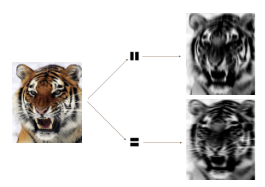

### 10.3.2 プーリング層

プーリング層では$2 \times 2$のブロックごとに最大値のような代表値を決め、それを新たな出力とすることで画像を圧縮する。また、ある程度の位置のばらつきを吸収する効果もある。

### 10.3.3 CNNの構造

通常、CNNでは畳み込みやプーリングを何回か繰り返す。

隠れ層を適切に組み合わせてCNNを構築することは困難ではあるが、優れたソフトウェアがそれをサポートしてくれる。

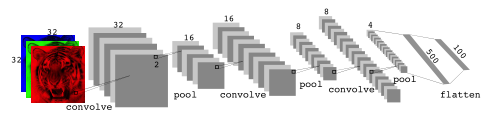

### 10.3.4 データ拡張

訓練データの画像を傾けたり、歪ませたりすることで新たな訓練データを生成することができる。一つの画像の周囲にそれに似た画像を多数配置することでRidgeのような正則化の効果が期待できる。


### 10.3.5 学習済みモデルの使用

モデルの学習にはコストがかかるため、予め学習が終わっているモデルを使うこともできる。

In [ ]:
import torch
import torchvision.models as models
from torchsummary import summary


mydevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("mydevice = ", mydevice)
model = models.vgg16(pretrained=True)
model = model.to(mydevice)
model.eval()
summary(model, input_size=(3, 224, 224))

In [ ]:
# サンプル画像のダウンロード
! wget "https://github.com/pytorch/hub/raw/master/images/dog.jpg"

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("dog.jpg")
plt.imshow(img)

In [ ]:
from torchvision import transforms

transform = transforms.Compose(
    [
        transforms.Resize(256),  # (256, 256) の大きさに変形する
        transforms.CenterCrop(224),  # 画像の中心に合わせて(224, 224) で切り抜く
        transforms.ToTensor(),  # テンソルにする
        transforms.Normalize(  # 標準化する
            mean=[0.485, 0.456, 0.406],  # 平均
            std=[0.229, 0.224, 0.225],  # 分散
        ),
    ]
)
img_tensor = transform(img)

In [ ]:
import numpy as np

def show_img_tensor(img_tensor_):
    """tensorに変換した画像を表示する"""
    img1 = img_tensor_.numpy().transpose((1, 2, 0)) # (Ch, H, W) を (H, W, Ch) 変換
    img2 = np.clip(img1, 0, 1)         # 0 から 1 の間にクリッピングする
    plt.imshow(img2)
    plt.show()
    
show_img_tensor(img_tensor)

In [ ]:
# 日本語ラベルデータの取得
from pathlib import Path
from torchvision.datasets.utils import download_url
import json

filename = "data/imagenet_class_index.json"

def get_classes():
    if not Path(filename).exists():
        download_url("https://git.io/JebAs", "data", "imagenet_class_index.json")

    with open(filename) as f:
        data = json.load(f)
        class_names = [x["ja"] for x in data]    # 日本語版
        # class_names = [x["en"] for x in data]   # 英語版
    return class_names

class_names = get_classes()

In [ ]:
from torch.nn import functional as F

inputs = img_tensor.unsqueeze(0).to(mydevice)
outputs = model(inputs)

batch_probs = F.softmax(outputs, dim=1)
batch_probs, batch_indices = batch_probs.sort(dim=1, descending=True)

for probs, indices in zip(batch_probs, batch_indices):
    for k in range(5):
        idx = indices[k]
        prob = probs[k]
        print(f"({k+1}) {class_names[idx]} \t{prob:.2%}")

## 10.4 文章分類

現代の重要なトピックとして文章の属性を予測する、というものがある。例えば`IMDb`(Internet Movie Database)というデータベースには次のような映画のレビューが25000件存在する。

> This has to be one of the worst films of the 1990s. When my friends & I were watching this film (being the target audience it was aimed at) we just sat & watched the first half an hour with our jaws touching the floor at how bad it really was. The rest of the time, everyone else in the theater just started talking to each other, leaving or generally crying into their popcorn ...

これらのデータから、あるレビューがその映画に対して肯定的か否定的かを判定するモデルを作成したい。

学習にあたって文章の特性を数値化したい。そのための手法の一つとして**bag-of-words**モデルというものが存在する。このモデルでは、文章を特定の単語が含まれるかどうかでスコアをつける。辞書が$M$個の単語を含んでおり、文章からは$M$要素の特徴ベクトルが生成される。$M_i$は文章中に辞書の$i$番目の単語が含まれれば$1$、そうでなければ$0$である。

このようなベクトルの作成には便利なツールが存在する。ツールにより前処理されたレビューは次のようになる。

> ⟨START⟩ this film was just brilliant casting location scenery story direction everyone’s really suited the part they played and you could just imagine being there robert ⟨UNK⟩ is an amazing actor and now the same being director ⟨UNK⟩ father came from the same scottish island as myself so i loved ...

処理によって多くの単語が取り除かれ、不明な単語には\<UNK\>というタグに置き換わっている。

このように変換されたデータセットは $M\times N$ 要素$(10000 \times 25000)$という大きい行列になるが、この中で非ゼロの値は全体の約$1.3\%$しか存在しない。このような行列は**疎行列**と呼ばれ、データの持ち方を工夫すれば効率的に計算をすることができる。

In [ ]:
mat = [
    [0, 0, 1, 0, 1],
    [0, 1, 0, 0, 1],
    [0, 0, 0, 0, 0],
    [1, 0, 1, 0, 1],
]


def make_lil(mat):
    lil = [[] for _ in range(len(mat))]
    for i, row in enumerate(mat):
        for j, data in enumerate(row):
            if data == 1:
                lil[i].append(j)

    return lil


lil = make_lil(mat)
for i, l in enumerate(lil):
    print(f"{i}: {l}")


得られた行列に対し、L1正則化ロジスティック回帰やニューラルネットワークで学習を行う事ができる。

bag-of-wordsモデルでは文章内をそこに存在する単語で要約し、単語同士のつながりといった文脈を無視する。

文脈を考慮する方法としては連続するn単語に対して存在判定をするbag-of-n-gramsモデルや、文章を時系列データとみなして分析をする手法などがある。

In [ ]:
from itertools import chain

import keras.datasets.imdb
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=10000)

In [ ]:
# Retrieve the word index file mapping words to indices
word_index = keras.datasets.imdb.get_word_index()
# Reverse the word index to obtain a dict mapping indices to words
inverted_word_index = dict((i, word) for (word, i) in word_index.items())
# Decode the first sequence in the dataset
# decoded_sequence = " ".join(inverted_word_index[i] for i in X_train[0])

def decode_sequence(seq):
    return " ".join(inverted_word_index[i] for i in seq)

In [ ]:
X_train_text = [decode_sequence(seq) for seq in X_train]
X_test_text = [decode_sequence(seq) for seq in X_test]

count = CountVectorizer(binary=True)
bag = count.fit(chain(X_train_text, X_test_text))

X_train_bag = bag.transform(X_train_text)
X_test_bag = bag.transform(X_test_text)

In [ ]:
from sklearn.linear_model import LogisticRegression

model_logit = LogisticRegression(penalty="l1", solver="liblinear")
model_logit.fit(X_train_bag, y_train)

In [ ]:
accuracy_for_train = model_logit.score(X_train_bag, y_train)
accuracy_for_test  = model_logit.score(X_test_bag,  y_test)

print("accuracy for training data is ", accuracy_for_train)
print("accuracy for test data is     ", accuracy_for_test)

## 10.5 Recurrent Neural Networks (RNN)



RNNは**系列データ**に対して使われる。

* 書評、映画評、新聞記事、ツイートなどの文書。文章中の単語の並びや相対的な位置関係から、文章の語り口やテーマ、語調を捉えて、トピック分類、感情分析、言語変換などを行う。
* 気温、降水量、風速、大気質などの時系列データ。天気予報を行う。
* 市場指数、取引量、株価、債券価格、為替レートなどの金融の時系列データ。一般にこれらの予測は難しいことが多いが、それなりの精度で予測することができるものもある。
* 録音された音声。文字起こしや音楽の評価、属性の付与を行う。
* 手書きの文字、数字。手書き文字を読み取り、デジタルデータに変換する。いわゆるOCR


IMDbのような文章のコーパスについて考える。それぞれの文章は$L$単語の系列として表現される。したがって、入力は $X = \{X_1, \dots, X_L\}$ となる。(各$X_l$は1単語を表す。)

文章は、単語は並びや特定の単語同士の位置関係によって意味づけられる。CNNが画像の空間構造を認識したように、RNNは入力の連続性に対応するように設計されている。

出力である$Y$は翻訳の場合などにはベクトルであることもあるが、2値の感情分析のようなスカラーであることも多い。

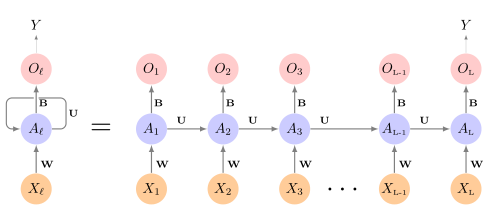

RNNは $X = \{X_1, \dots, X_L\}$ を入力、$Y$を出力とし、$L$要素の隠れ層の配列$\{A_l\}_1^L = \{A_1, \dots, A_L\}$ を持つ。

各$X_l$ はベクトルであり、文章の例では $l$番目の単語を one-hot encoding したものである。

各隠れ層は順に処理され、隠れ層$A_l$の更新には $X_l$ と $A_{l-1}$ が使われる。 $A_l$ は出力層 $O_l$ に送られ、最後の要素である $O_L$ が出力として扱われる。

より詳細には、入力 $X_l^T=(X_{l1}, X_{l2}, \dots , X_{lp})$ には $p$ 個の要素が含まれ、各隠れ層 $A_l^T=(A_{l1}, A_{l2}, \dots , A_{lK})$ には $K$ 個のユニットが含まれる。入力を変換する $K \times (p+1)$ 要素の重み$W$ 、手前の隠れ層からの変換に使われる重み $K \times K$ 要素の重み $U$ 、出力層への変換に使われる $K+1$要素の重み $B$ にはそれぞれニューラルネットワーク全体で共有される。(weight shareing)

隠れ層を数式で表すと、

$$
A_{lk} = g\left(w_{k0} + \sum_{j=1}^{p}w_{kj}X_{lj} + \sum_{s=1}^{K}u_{ks}A_{l-1, s}\right)
$$

出力には、量的な応答の場合、

$$
O_l = \beta_0 + \sum_{k=1}^{K}\beta_{k}A_{lk}
$$

2値応答の場合はこれにシグモイド関数を適用したものが使われる。

$A_l$ はそれ以前の隠れ層を累積したものになっており、それまでに学習した文脈を予測に使うことができる。

回帰問題の場合、損失関数には $\sum_{i=1}^{n}(Yi-O_{iL})^2$ が使われる。

学習を行うと、各 $X_i$ は間接的に $W, U, B$ に影響を与える。

ここでは、$O_1, \dots , O_{L-1}$は使われないが、出力も系列である時などに追加の予測を提供する。

### 10.5.1 文章分類の系列モデル

IMDbの分類問題を扱う。前回はbug-of-oneモデルを適用したが、今回は文章を系列として捉えたい。

現状、一つの単語に10000要素（辞書の大きさ）のベクトルが対応しているため、次元の問題が発生している。これに対処するための一般的な手法として、単語をより低次元のベクトル空位に埋め込むというものがある。この手法では、9999個の0と1個の1で構成されたベクトルを基本的に非ゼロの $m$ 個の実数で表す。（$m$は数百程度）
これには $m \times 10000$ 要素の行列 $E$ が必要。

データセットが十分大きければニューラルネットワークに埋め込み層を追加して $E$ を学習させることができる。
この場合、タスクに特化した $E$ が学習される。他にも学習済みの $E$ を使うことができ、この処理は **weight freezing** と呼ばれる。学習済みの $E$ としては `word2vec`と`GloVe`の2つが多く使われている。この埋め込みは**主成分分析**の一種で、埋め込まれた空間において近い位置にある単語同士は意味も似ているという性質がある。






IMDb に対して $L = 500, N = 25000, m = 32, K = 32$ で学習をおこなう。

先程のモデルに**ドロップアウト層**を追加したモデルでは76%の精度しか出なかった。これはこのモデルが非常に単純だからであり、発展的なモデルとしては、長期記憶と短期記憶 (**LSTM**) を使った物がある。これは、隠れ層の計算を直近の隠れ層と過去の隠れ層から行うことで、隠れ層の数が多いときに初期の情報がだんだんと薄まっていってしまうという問題に対処している。

LSTMを使った場合でも、bug-of-oneモデルと同等の87%の精度しか出ていない。しかし、モデルをより改善することで、近年では95%の精度が出ている。

### 10.5.2 時系列予測


1962年12月3日から1986年12月31日のニューヨーク株式市場における3種類の取引データがある。

* `Log trading volume`: 100日の移動平均におけるその日の出来高の割合（対数スケール）
* `Dow Jones return`: 連続営業日のダウ平均株価の差（対数スケール）
* `Log volatility`: 日々の値動きの絶対値から計算される（対数スケール）

株価を予測するのは難しいが、過去のデータから出来高を予測するのは比較的やりやすく、取引戦略を立てる上でも有用である。$(v_t, r_t, z_t)$ をそれぞれ、`log volume`, `DJ return`, `log volatility`の $t$ 日目の観測値とするとこの組は $T=6051$ 個存在する。





In [3]:
%load_ext rpy2.ipython

In [6]:
%%R
install.packages("ISLR2", quiet = T)
library(ISLR2)

In [7]:
%%R -o df
df <- ISLR2::NYSE
summary(df)

     date           day_of_week          DJ_return            log_volume       
 Length:6051        Length:6051        Min.   :-0.0471770   Min.   :-1.322425  
 Class :character   Class :character   1st Qu.:-0.0046400   1st Qu.:-0.159956  
 Mode  :character   Mode  :character   Median : 0.0001250   Median :-0.013249  
                                       Mean   : 0.0001771   Mean   :-0.008336  
                                       3rd Qu.: 0.0047920   3rd Qu.: 0.131632  
                                       Max.   : 0.0495170   Max.   : 1.039370  
 log_volatility      train        
 Min.   :-13.127   Mode :logical  
 1st Qu.:-10.334   FALSE:1770     
 Median : -9.844   TRUE :4281     
 Mean   : -9.843                  
 3rd Qu.: -9.380                  
 Max.   : -7.478                  


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [9]:
data:pd.DataFrame = df
data["date"] = pd.to_datetime(data["date"])
print(data.columns)
print(data.shape)

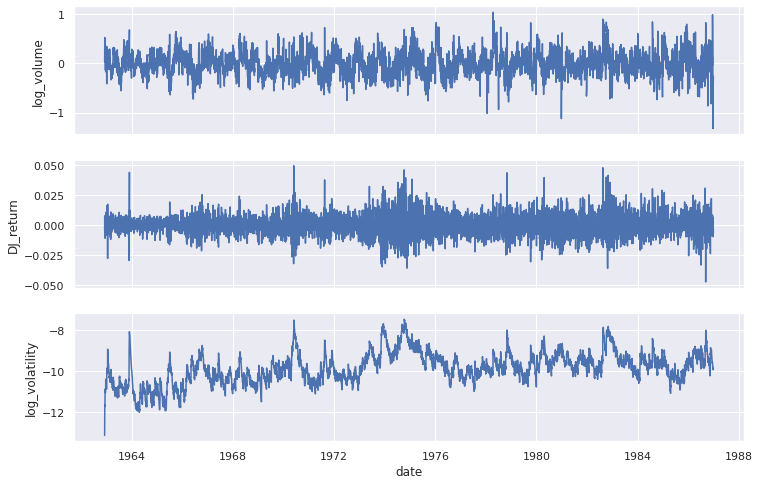

In [19]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12,8))

sns.lineplot(data=data, x="date", y="log_volume", ax=axs[0])
sns.lineplot(data=data, x="date", y="DJ_return", ax=axs[1])
sns.lineplot(data=data, x="date", y="log_volatility", ax=axs[2])
plt.show()

時系列は互いに独立したものではなく、時間的に近い値は似ている（**自己相関**）

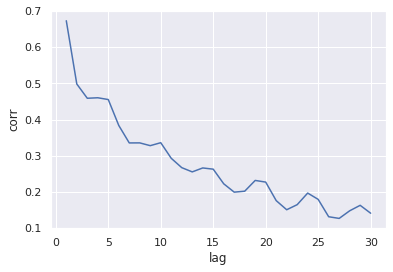

In [21]:
x = list(range(1, 31))
y = []
for l in x:
    lag = data["log_volume"].shift(l)
    y.append(data["log_volume"].corr(lag))


plt.plot(x, y)
plt.xlabel("lag")
plt.ylabel("corr")
plt.show()


時系列予測の場合、応答変数が説明変数であるのも特徴の一つ。

#### RNN 予測機

$v_t$ を $v_{t-1}, v_{t-2}, \dots$ と、他にも $r_{t-1}, r_{t-2}, \dots$ や $z_{t-1}, z_{t-2}, \dots$ を使って予測したい。6051日分の取引データが含まれるが、以下の点で今までと異なる。

* データが1本しか無い
* ターゲットの過去のデータが入力に含まれる。

文章分類の場合と同じような構造にするために、長さが $L$ の連続時系列 $X = \{X_1, \dots , X_L\}$ とそれに対応する $Y$ を多数抽出する。例えば、 $Y = v_t$となるように抽出するなら、

$$
X_1 = (v_{t-L}, r_{t-L}, z_{t-L}), X_2 = (v_{t-L+1}, r_{t-L+1}, z_{t-L+1}), \dots , X_L = (v_{t-1}, r_{t-1}, z_{t-1})
$$

$L = 5$ とした場合、 6046個の部分時系列を抽出できる。 $L$ は慎重に選ばなければならない。

1980年1月2日以前から4281個のデータを抽出し、 隠れ層のユニット数 $K=12$ のRNN でそれ以降のデータ1770個を予測した結果、テストデータに対して $R^2 = 0.42$ を達成した。(前日の`log_volume`をそのまま予測値とした場合は $R^2 = 0.18$)

In [ ]:
X_train = data[["log_volume", "DJ_return", "log_volatility"]]

#### Autoregression

今回のRNNモデルはAR(L)モデルにかなり似ている。$L = 5$ のARモデルで予測を行った場合、テストデータに対して $R^2 = 0.41$ となりRNNの場合よりわずかに小さい。

RNNとARモデルの違いはパラメータの数である。今回の場合、AR(5)モデルのパラメータ数は $L\times p +1 = 5 \times 3 + 1 = 16$ であるが、$K=12$のRNNのパラメータ数は $(K \times (p+1)) + (K \times K) + (K + 1) = 205$ 個になる。

ARモデルを拡張する場合、入力を通常のニューラルネットワークの入力層に入れ、モデルの柔軟性を高めるというものがある。この場合、テストデータに対する$R^2 = 0.42$ と僅かに改善する。

他にも、質的変数として曜日を追加する事が考えられる。これは取引が月曜と金曜に集中することを反映するためで、ARモデルの$R^2 = 0.46$ 、非線形ARモデルの $R^2 = 0.47$ となる。

さらに、RNNにLSTMを加えれば、1%程度 $R^2$ が改善する。



### 10.5.3 RNNのまとめ

RNNには多くのバリエーションと拡張が存在する。例えば、系列に対して1次元の畳み込みニューラルネットワークを使うことで、短いフレーズなどを対象にした学習を可能にする。また、翻訳を行う場合は隠れ層を追加することで、新たな隠れ層が文章の意味付けを行うとされている。

### 10.6 深層学習を使うにあたって

深層学習は、他の学習方法では困難だった問題に対して大きな力を発揮した。しかし、これは深層学習が他よりも真に優れており、全ての問題に対して深層学習を使うべきであるということは意味しない。深層学習で他の手法の同等のパフォーマンスを出すのにはパラメータのチューニングに時間が掛かるからだ。また、事象のもととなるモデルが判明した場合は、線形回帰モデルが深層学習よりも良いパフォーマンスを出すこともある。一般に深層学習はサンプルサイズが大きく、モデルの解釈可能性がそれほど重要でない場合に力を発揮する。